# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

import random

import xgboost as xgb
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from pathlib import Path

import joblib

## 1.1. Defining paths

In [2]:
FOLDER_PATH = Path("../data/processed")
MODEL_PATH = Path("../model")

## 1.2. Loading data

In [3]:
df_train = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "train.csv", low_memory=False)
df_test = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "test.csv", low_memory=False)

In [4]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# 2. Machine learning model

In [5]:
def root_mean_square_percentage_error(y_true, y_pred):
    rmspe = np.sqrt(np.mean(((y_true.values.reshape(len(y_true)) - y_pred) / y_true.values.reshape(len(y_true)))**2))
    return rmspe

def model_performance(y_true, y_pred):
    rmspe = root_mean_square_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return pd.DataFrame({'RMSPE': rmspe,
                         'RMSE': rmse,
                         'MAPE': mape},
                         index=[0])

## 2.1. Defining train and test sets

In [6]:
seed = 42

In [7]:
X_train = df_train.drop(columns=["Date", "Sales", "Customers"])
y_train = df_train[["Sales"]]

In [8]:
X_test = df_test.drop(columns=["Date", "Sales", "Customers"])
y_test = df_test[["Sales"]]

In [9]:
# Checking if both datasets have the same columns
assert len(X_train.columns) == len(X_test.columns), 'Different columns between X_train and X_test'

## 2.2. Baseline

### 2.2.1. Média móvel

### 2.2.2. Linear Regression

,Store,Date,Sales
0,1,2015-06-13,4256
1,1,2015-06-15,5518
2,1,2015-06-16,4852
3,1,2015-06-17,4000
4,1,2015-06-18,4645
...,...,...,...
46825,292,2015-07-06,3754
46826,292,2015-07-07,3077
46827,292,2015-07-08,2406
46828,292,2015-07-09,4777


In [10]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred_lin_reg = lin_reg_model.predict(X_test)

In [35]:
df_baseline = df_test[["Store", "Date", "Sales"]].copy()

In [36]:
df_baseline["Predicted"] = y_pred_lin_reg.ravel()

In [20]:
model_performance(y_true=y_test,y_pred=y_pred_lin_reg.ravel())

,RMSPE,RMSE,MAPE
0,0.208452,1278.3745,0.14114


## 2.3. XGBoost - First approach using all columns

In [13]:
reg_xgb = xgb.XGBRegressor(n_estimators = 500, enable_categorical=True, tree_method="hist", random_state=seed)
reg_xgb.fit(X=X_train, y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
y_pred_xgb = reg_xgb.predict(X=X_test)

In [15]:
# Evaluating model performance
model_performance(y_true=y_test, y_pred=y_pred_xgb)

,RMSPE,RMSE,MAPE
0,0.136835,901.637451,0.093138


## 2.4. Feature importance filtering

In [ ]:
plot_importance(reg_xgb, importance_type="weight",
#plot_importance(reg_xgb, importance_type="gain",
                max_num_features=20,
                height=1,
                title="Top 20 Feature Importance",
                show_values=False);

In [ ]:
importances = reg_xgb.get_booster().get_score(importance_type="weight")
#importances = reg_xgb.get_booster().get_score(importance_type="gain")

feature_importances = pd.DataFrame(list(importances.items()),
                                   columns=["Feature", "Importance"])\
                                  .set_index("Feature").sort_values(by="Importance", ascending=False)

In [ ]:
# Using this to manually select the best k features
for k in range(1, (len(feature_importances)+1)):
    topKfeat = feature_importances.iloc[:k,:].index
    reg_xgb_filtered = xgb.XGBRegressor(n_estimators = 800, enable_categorical=True, random_state=seed)
    reg_xgb_filtered.fit(X=X_train[topKfeat], y=y_train)
    y_pred_xgb_filtered = reg_xgb_filtered.predict(X=X_test[topKfeat])
    rmspe = root_mean_square_percentage_error(y_true=y_test, y_pred=y_pred_xgb_filtered)
    rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred_xgb_filtered)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb_filtered)
    print(f"Number of features={k}: RMSPE={rmspe:.4f}, RMSE={rmse:.2f}, MAPE={mape:.4f}")

## 2.5. Hyperparameter tunning

In [ ]:
# Choosing top 14 features
k = 14

topKfeat = feature_importances.iloc[:k,:].index

In [ ]:
reg_xgb_tun = xgb.XGBRegressor(enable_categorical=True,
                               random_state=seed)

In [ ]:
# Using TimeSeriesSplit to ensure that the validation set is always after the training set in cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Searching space
xgb_space = {
    "n_estimators": Integer(100, 5000),
    "max_depth": Integer(3,10),
    "learning_rate": Real(0.001, 0.5, prior="log-uniform"),
    "subsample": Real(0.05, 1.0, prior="uniform"),
    "colsample_bytree": Real(0.1, 1.0, prior="uniform"),
    "min_child_weight": Real(1, 10),
    "reg_alpha": Real(0.0, 1.0, prior="uniform"),
    "reg_lambda": Real(0.0, 5.0, prior="uniform"),
    "gamma": Real(0.0, 5.0, prior="uniform")
}

reg_xgb_opt = BayesSearchCV(estimator=reg_xgb_tun,
                            search_spaces=xgb_space,
                            scoring="neg_root_mean_squared_error",
                            n_iter=10,
                            cv=tscv,
                            random_state=seed,
                            n_jobs=-1)

In [ ]:
reg_xgb_opt.fit(X=X_train[topKfeat], y=y_train)

In [ ]:
reg_xgb_opt.best_score_*(-1)

In [ ]:
best_params = reg_xgb_opt.best_params_
best_params

## 2.6. Saving model

In [ ]:
# Saving model and top k feature names
joblib.dump(value=[reg_xgb_opt, topKfeat], filename=MODEL_PATH / "xgb_model_tuned.pkl")

# 3. Predictions

## 3.1. Loading model

In [21]:
model_loaded, topKfeatures_loaded = joblib.load(filename=MODEL_PATH / "xgb_model_tuned.pkl")

## 3.2. Model performance

### 3.2.1. General

In [22]:
y_pred = model_loaded.predict(X=X_test[topKfeatures_loaded])

model_performance(y_true=y_test, y_pred=y_pred)

,RMSPE,RMSE,MAPE
0,0.143219,918.461609,0.098532


### 3.2.2. Example for a random store

In [25]:
# Randomly choosing a store to make predictions
store_number = random.randint(1, X_test["Store"].nunique())

df_pred = df_test[["Store", "Date", "Sales"]].copy()
df_pred["Predicted_Sales"] = y_pred
store_sales = df_pred[df_pred["Store"] == store_number]["Predicted_Sales"]

rmspe = root_mean_square_percentage_error(y_true=df_pred[df_pred["Store"] == store_number]["Sales"], y_pred=store_sales)

print(f"The sales forecast for store {store_number} in the next six weeks is US$ {store_sales.sum():.2f}")
print(f"Local RMSPE: {rmspe:.4f}")

The sales forecast for store 478 in the next six weeks is US$ 288506.66
Local RMSPE: 0.1324


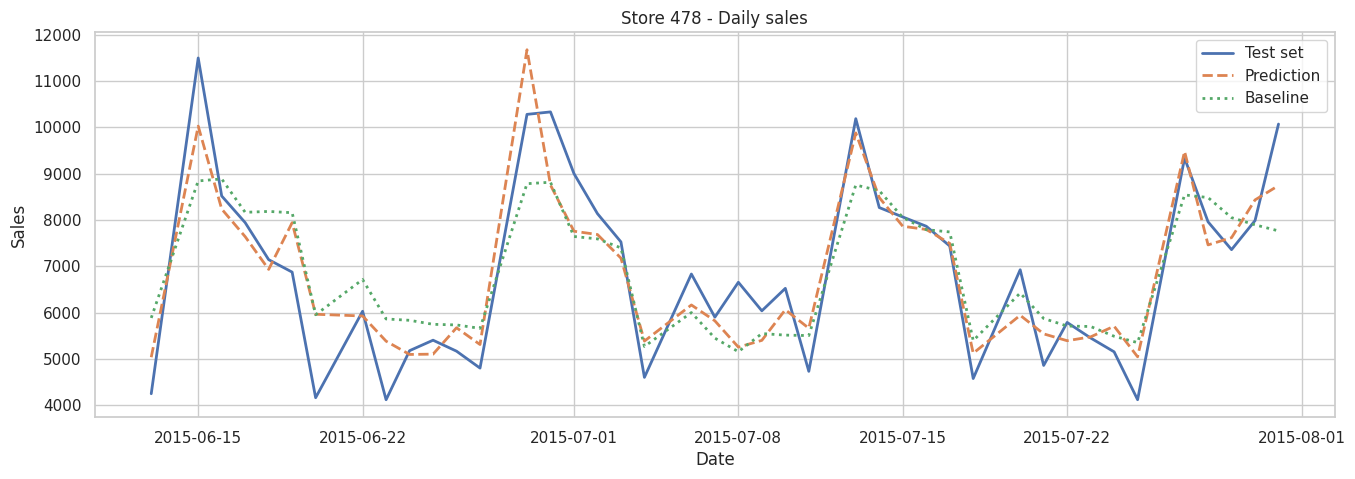

In [37]:
# The model was able to capture the main trends of the test set.
fig, ax = plt.subplots(figsize=(16,5))
sns.lineplot(data=df_pred[df_pred["Store"] == store_number], x="Date", y="Sales", label="Test set", lw=2)
sns.lineplot(data=df_pred[df_pred["Store"] == store_number], x="Date", y="Predicted_Sales", label="Prediction", lw=2, linestyle="--")
sns.lineplot(data=df_baseline[df_baseline["Store"] == store_number], x="Date", y="Predicted", label="Baseline", lw=2, linestyle=":")
plt.title(f"Store {store_number} - Daily sales");

The model was able to capture the main trends of the test set.